In [ ]:
!pip install lifelines

In [ ]:
import lifelines 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from util import load_data 
from lifelines import KaplanMeierFitter as km
from lifelines.statistics import logrank_test

In [ ]:
data = load_data()

In [ ]:
print("data shape: {}".format(data.shape))
data.head()

data shape: (80, 3)


,Stage_group,Time,Event
0,1,6,1
1,1,19,1
2,1,32,1
3,1,42,1
4,1,42,1


Text(0, 0.5, 'Frequency (number of patients)')

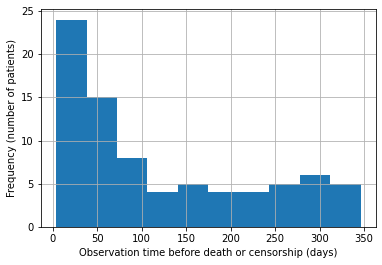

In [ ]:
data.Time.hist()
plt.xlabel("Observation time before death or censorship (days)")
plt.ylabel("Frequency (number of patients)")

In [ ]:
def frac_censored(df):
  result = 0.0
  result = sum(df.Event==0) / df.shape[0]
  return result

In [ ]:
print(frac_censored(data))

0.325


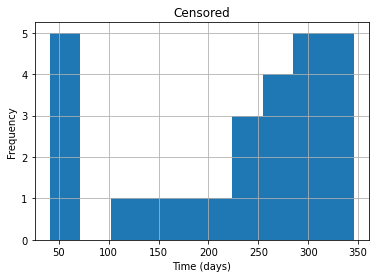

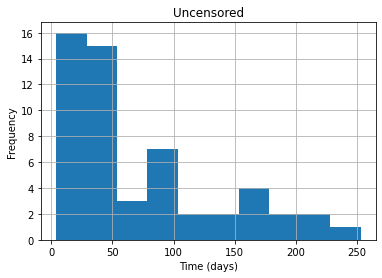

In [ ]:
df_censored = data[data.Event == 0]
df_uncensored = data[data.Event == 1]

df_censored.Time.hist()
plt.title("Censored")
plt.xlabel("Time (days)")
plt.ylabel("Frequency")
plt.show()

df_uncensored.Time.hist()
plt.title("Uncensored")
plt.xlabel("Time (days)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
 '''
 Return naive estimate for S(t), the probability
    of surviving past time t. Given by number
    of cases who survived past time t divided by the
    number of cases who weren't censored before time t.

In [ ]:
def naive_estimator(t,df):
  s_t = 0.0
  s_t = sum(df.Time > t) / sum((df.Event == 1) | (df.Time > t)) 
  return s_t

In [ ]:
print("Test Cases")
sample_df = pd.DataFrame(columns = ["Time", "Event"])
sample_df.Time = [5, 10, 15]
sample_df.Event = [0, 1, 0]
print("Test Case : S(3)")
print("Output: {}, Expected: {}\n".format(naive_estimator(3, sample_df), 1.0))

Test Cases
Test Case : S(3)
Output: 1.0, Expected: 1.0



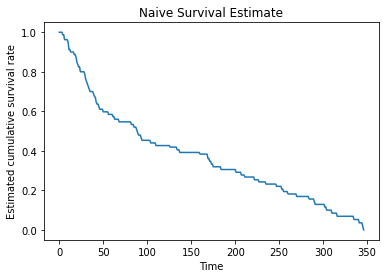

In [ ]:
max_time = data.Time.max()
x = range(0,max_time+1)
y = np.zeros(len(x))
for i,t in enumerate(x):
  y[i] = naive_estimator(t,data)
plt.plot(x, y)
plt.title("Naive Survival Estimate")
plt.xlabel("Time")
plt.ylabel("Estimated cumulative survival rate")
plt.show()

<a name="kaplan-meier"></a>
## Kaplan-Meier

The Kaplan Meier estimate of survival probability is:

$$
S(t) = \prod_{t_i \leq t} (1 - \frac{d_i}{n_i})
$$

- $t_i$ are the events observed in the dataset 
- $d_i$ is the number of deaths at time $t_i$
- $n_i$ is the number of people who we know have survived up to time $t_i$.


In [ ]:
'''
 Args:
        df (dataframe): dataframe which has columns for Time
                          and Event, defined as usual.
                          
    Returns:
        event_times (list of ints): array of unique event times
                                      (begins with 0).
        S (list of floats): array of survival probabilites, so that
                            S[i] = P(T > event_times[i]). This 
                            begins with 1.0 (since no one dies at time
                            0).
    """

In [ ]:
def homemadekm(df):
  event_times = [0]
  p = 1.0
  s = [p]
  observed_event_times = df.Time.unique()
  observed_event_times = np.sort(observed_event_times)
  for t in observed_event_times:
    n_t = sum(df.Time >= t)
    d_t = sum((df.Time == t) & (df.Event == 1))
    p *= 1. - (d_t/n_t)
    s.append(p)
    event_times.append(t)
  return event_times,s

In [ ]:
sample_df = pd.DataFrame(columns = ["Time", "Event"])
sample_df.Time = [5, 10, 15]
sample_df.Event = [0, 1, 0]
print(sample_df.head())
x, y = homemadekm(sample_df)
print("Event times: {}, Survival Probabilities: {}".format(x, y))

   Time  Event
0     5      0
1    10      1
2    15      0
Event times: [0, 5, 10, 15], Survival Probabilities: [1.0, 1.0, 0.5, 0.5]


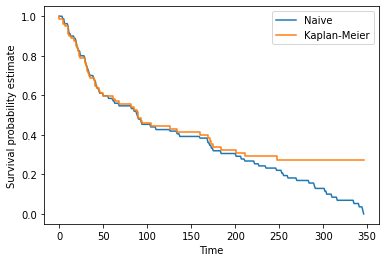

In [ ]:
max_time = data.Time.max()
x = range(0, max_time+1)
y = np.zeros(len(x))
for i, t in enumerate(x):
    y[i] = naive_estimator(t, data)
    
plt.plot(x, y, label="Naive")
x, y = homemadekm(data)
plt.step(x, y, label="Kaplan-Meier")
plt.xlabel("Time")
plt.ylabel("Survival probability estimate")
plt.legend()
plt.show()

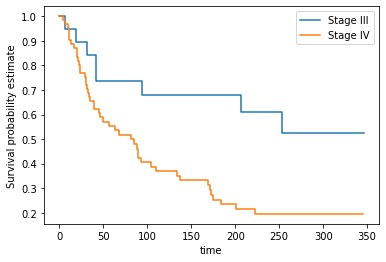

In [ ]:
S1 = data[data.Stage_group == 1]
km1 = km()
km1.fit(S1.loc[:, 'Time'], event_observed = S1.loc[:, 'Event'], label = 'Stage III')
S2 = data[data.Stage_group == 2]
km2 = km()
km2.fit(S2.loc[:, "Time"], event_observed = S2.loc[:, 'Event'], label = 'Stage IV')
ax = km1.plot(ci_show=False)
km2.plot(ax = ax, ci_show=False)
plt.xlabel('time')
plt.ylabel('Survival probability estimate')
plt.savefig('two_km_curves', dpi=300)

In [ ]:
survivals = pd.DataFrame([90, 180, 270, 360], columns = ['time'])
survivals.loc[:, 'Group 1'] = km1.survival_function_at_times(survivals['time']).values
survivals.loc[:, 'Group 2'] = km2.survival_function_at_times(survivals['time']).values

In [ ]:
survivals

,time,Group 1,Group 2
0,90,0.736842,0.424529
1,180,0.680162,0.254066
2,270,0.524696,0.195436
3,360,0.524696,0.195436


In [ ]:
'''
If everything is correct, you should see a p value of less than 0.05, 
which indicates that the difference in the curves is indeed statistically significant.

In [ ]:
def logrank_p_value(group_1_data, group_2_data):
    result = logrank_test(group_1_data.Time, group_2_data.Time,
                          group_1_data.Event, group_2_data.Event)
    return result.p_value

logrank_p_value(S1, S2)

0.009588929834755544